In [1]:
%load_ext autoreload
%autoreload 2

import scipy
import numpy as np
import matplotlib.pyplot as plt
import keras
# use torch backend
import torch

import time




2024-08-29 12:40:59.943585: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-29 12:40:59.979717: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 12:40:59.979752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 12:40:59.980588: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 12:40:59.986255: I tensorflow/core/platform/cpu_feature_guar

## Observations
At each timestep $t$, we observe a vector $y_t$. The observed value $y_{t}$ is realization of random variable $Y$, which is normally distributed with unit variance and a mean: $Y_{t} \sim \mathcal{N}(\mu, 1)$. The mean is $\mu = [0]$.

In [2]:
# Distribution Settings
scale = 1
mean = 0

normal_dist = scipy.stats.norm(loc=mean, scale=scale)

# Number of independent datapoints 
T = 1000

seed=360
rng = np.random.RandomState(seed)
y_T = torch.Tensor(normal_dist.rvs(size=T, random_state=rng))
y_T.requires_grad_(True)
""

''

In total, we observe $T=1000$ examples. Our goal is to train a model to accurately predict $y$.

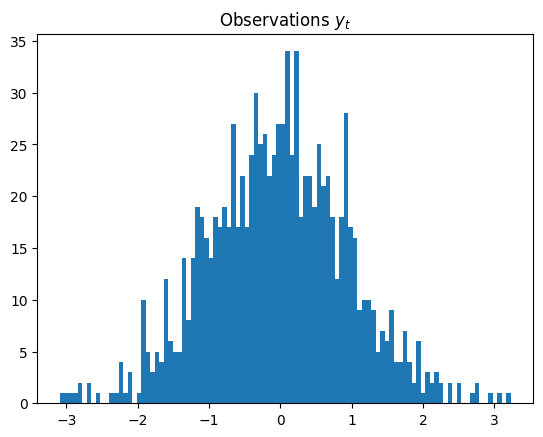

In [3]:
plt.hist(y_T.detach().numpy(), bins=100)
plt.title("Observations $y_t$")
plt.show()

## Model
We will model this with the true model: sample predictions $y^m_{t}$ will come from a normal distribution, where the mean is determined by the model's only parameter $\phi$ and the variance is fixed to the true value of $1$.

$$ y^m_{t} \sim \mathcal{N}(y_{t}| \phi, 1)$$
All locations are independent:

Our model can trivially recover the true data generating process by setting the parameter to the true mean $\phi = \mu$

## Objective
We will use our model's predictions $y$ in order to choose some action $r$, which can be calculated by a deterministic but not necessarily differentiable function $f$ of $M$ monte-carlo samples: $y^m$:
$$r_t = \frac{1}{M}\sum_m f(y^m_t)$$



Given a decision $r$, we can calculate a loss between our action and the observed outcome $\mathcal{L}(r_t, y_t)$. Our goal is to calculate gradients of that loss with respect to our model parameters. We can use the chain rule to decompose the gradient into two parts:
$$ \nabla_\phi \mathcal{L}(r_t, y_t) = \nabla_\phi r_t \nabla_r  \mathcal{L}(r_t, y_t)$$


### Differentiate the score function trick
We'll take and use the identity function as our action $f(y)=y$
$$ \nabla_\phi \mathcal{L}(r_t, y_t) = \nabla_\phi r_t \nabla_r  \mathcal{L}(r_t, y_t)$$

When $r$ is non-differentiable, we can obtain gradients using the score-function trick, where we can approximate the gradient using $M$ samples from our probabilistic model $p$
$$\nabla_\phi r = \frac{1}{M} \sum_{m=1}^M \nabla_\phi \log p(y_t^m) f(y_t^m)$$

Our loss is mean-squared error and easy to differentiate: 
$$\mathcal{L} (r_t, y_t) = (y_t-r_t)^2$$
$$\nabla_\phi \log p(y^m) = \nabla_\phi \left( -\log (\sigma) - \frac{1}{2}\log (2\pi) - \frac{1}{2}(\frac{y^m-\phi}{\sigma})^2 \right)$$
$$ \nabla_\phi \log p(y^m) = \frac{y^m-\phi_\mu}{\sigma^2} = y^m -\phi$$
$$\nabla_\phi r = \frac{1}{M} \sum_{m=1}^M (y^m - \phi_\mu) f(y^m)$$
 $$\nabla_r  \mathcal{L}(r_t, y_t) =  \nabla_r   (y_t-r_t)^2$$
 $$ = -2(y_t-r_t)$$

In [11]:
M = 1

start = time.time()

vals, losses, anal_grad_r, numer_grad_r, anal_grad_L, numer_grad_L, anal_grad, numer_grad = [], [], [], [], [], [], [], []

for param_value in np.linspace(-5, 5, 11, dtype=np.float32):

    param = torch.tensor([param_value], requires_grad=True)
    print(param_value)

    for trial in range(100):
        if trial % 500 ==0 and trial != 0:
            print(trial)

        # Get some samples from the implied distribution
        param_sized = param*torch.ones(T)
        distribution = torch.distributions.Normal(loc=param_sized, scale=1)
        samples_MT = distribution.sample(sample_shape=(M,))

        # calculate the log prob of those samples
        # log probs cannot be an argument, must be "baked" into function
        def get_log_probs_baked(param):
            param_sized = param*torch.ones(T)
            distribution = torch.distributions.Normal(loc=param_sized, scale=1)
            log_probs_MT = distribution.log_prob(samples_MT)

            return log_probs_MT
        
        analytical_grad_r_wrt_phi_MT = (samples_MT -param)*samples_MT
        jac_log_prob_MT = torch.autograd.functional.jacobian(get_log_probs_baked, (param), strategy='forward-mode', vectorize=True)
        autodiff_grad_r_wrt_phi_MT = jac_log_prob_MT * torch.unsqueeze(samples_MT, dim=-1)
        analytical_grad_r_wrt_phi_T = torch.mean(analytical_grad_r_wrt_phi_MT, dim=0)
        autodiff_grad_r_wrt_phi_T = torch.mean(autodiff_grad_r_wrt_phi_MT, dim=0)

        action_samples_MT = samples_MT#distribution.sample(sample_shape=(M,))
        expected_action_T = torch.mean(action_samples_MT, dim=0)
        expected_action_T.requires_grad_(True)

        loss_T = torch.nn.functional.mse_loss(expected_action_T, y_T)

        analytical_grad_L_wrt_r_T = -2.0*(y_T - expected_action_T)
        loss_T.backward()
        autodiff_grad_L_wrt_r_T = expected_action_T.grad

        analytical_grad_T = torch.unsqueeze(analytical_grad_r_wrt_phi_T * analytical_grad_L_wrt_r_T, 1)
        autodiff_grad_T = autodiff_grad_r_wrt_phi_T * torch.unsqueeze(autodiff_grad_L_wrt_r_T, 1)

        assert autodiff_grad_T.shape == analytical_grad_T.shape and autodiff_grad_T.shape == (T, 1)

        vals.append(param_value)
        losses.append(loss_T.detach().numpy())
        anal_grad_r.append(analytical_grad_r_wrt_phi_T.detach().numpy())
        numer_grad_r.append(autodiff_grad_r_wrt_phi_T.detach().numpy())
        anal_grad_L.append(analytical_grad_L_wrt_r_T.detach().numpy())
        numer_grad_L.append(autodiff_grad_L_wrt_r_T.detach().numpy())
        anal_grad.append(analytical_grad_T.detach().numpy())
        numer_grad.append(autodiff_grad_T.detach().numpy())

end = time.time()
elapsed = end - start

-5.0
-4.0
-3.0
-2.0
-1.0
0.0
1.0
2.0
3.0
4.0
5.0


Text(0.5, 1.0, '$\\nabla_\\phi \\mathcal{L}$, M=1,time: 1.46s')

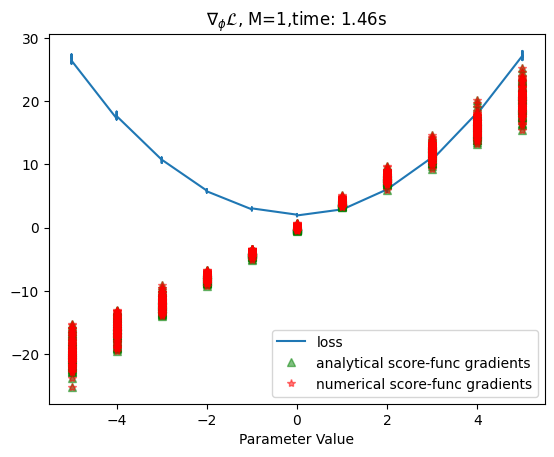

In [13]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Parameter Value')
ax1.plot(vals, losses, label='loss')

ax1.plot(vals, [np.mean(grad) for grad in anal_grad], 'g^',alpha=0.5, label='analytical score-func gradients')
ax1.plot(vals, [np.sum(grad) for grad in numer_grad], 'r*',alpha=0.5, label='numerical score-func gradients')
plt.legend()
plt.title(r'$\nabla_\phi \mathcal{L}$, '+f'M={M},time: {elapsed:.2f}s')

In [11]:
-

1100

(0.0, 5.0)

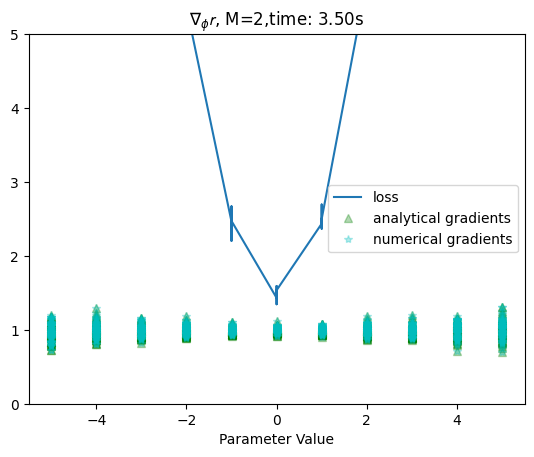

In [6]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Parameter Value')
ax1.plot(vals, losses, label='loss')

ax1.plot(vals, [np.mean(grad) for grad in anal_grad_r], 'g^', label='analytical gradients', alpha=0.3)
ax1.plot(vals, [np.mean(grad) for grad in numer_grad_r], 'c*', label='numerical gradients', alpha=0.3)
plt.legend()
plt.title(r'$\nabla_\phi \mathcal{r}$, '+f'M={M},time: {elapsed:.2f}s')
plt.ylim([0,5])

Text(0.5, 1.0, '$\\nabla_\\phi \\mathcal{r}$, M=2,time: 3.50s')

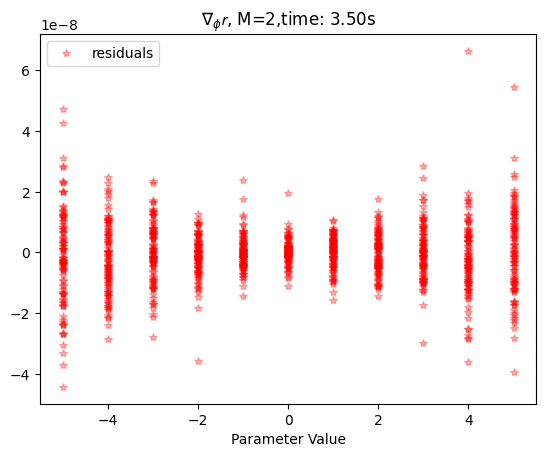

In [16]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Parameter Value')
#ax1.plot(vals, losses, label='loss')

#ax1.plot(vals, [np.mean(grad) for grad in anal_grad_r], 'g^', label='analytical gradients', alpha=0.3)
ax1.plot(vals, [np.mean((grada-gradn)) for grada, gradn in zip(anal_grad, numer_grad)], 'r*', label='residuals', alpha=0.3)
plt.legend()
plt.title(r'$\nabla_\phi \mathcal{r}$, '+f'M={M},time: {elapsed:.2f}s')
#plt.ylim([0,5])

In [9]:
anal_grad_r[-2][0]

7.298027

Text(0.5, 1.0, '$\\nabla_r \\mathcal{L}$, M=2,time: 3.50s')

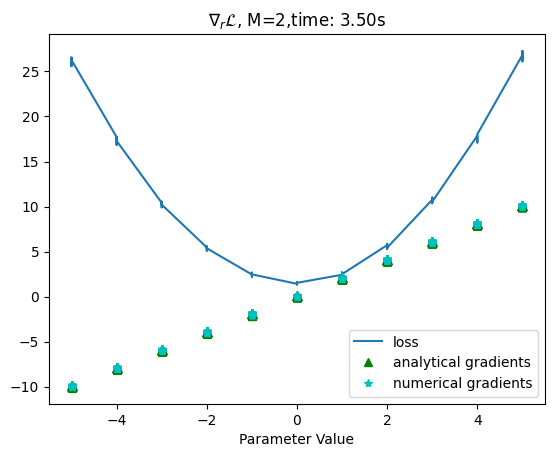

In [7]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Parameter Value')
ax1.plot(vals, losses, label='loss')

ax1.plot(vals, [np.mean(grad) for grad in anal_grad_L], 'g^', label='analytical gradients')
ax1.plot(vals, [np.sum(grad) for grad in numer_grad_L], 'c*', label='numerical gradients')
plt.legend()
plt.title(r'$\nabla_r \mathcal{L}$, '+f'M={M},time: {elapsed:.2f}s')

In [8]:
anal_grad_L-numer_grad_L

TypeError: unsupported operand type(s) for -: 'list' and 'list'